<a href="https://colab.research.google.com/github/flying-smoothly/AI_vision/blob/master/detect_to_objectbaggenerationadd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install pyrealsense2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 35.6 MB/s eta 0:00:00


In [ ]:
import cv2                                # state of the art computer vision algorithms library
import numpy as np                        # fundamental package for scientific computing
import matplotlib.pyplot as plt           # 2D plotting library producing publication quality figures
import pyrealsense2 as rs                 # Intel RealSense cross-platform open-source API
print("Environment Ready")

pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 15)
config.enable_stream(rs.stream.color, 1920, 1080, rs.format.rgb8, 15)
profile = pipeline.start(config)

filt = rs.save_single_frameset()

for x in range(100):
    pipeline.wait_for_frames()

frame = pipeline.wait_for_frames()
filt.process(frame)

In [5]:
import cv2                                # state of the art computer vision algorithms library
import numpy as np                        # fundamental package for scientific computing
import matplotlib.pyplot as plt           # 2D plotting library producing publication quality figures
import pyrealsense2 as rs                 # Intel RealSense cross-platform open-source API
print("Environment Ready")

# Setup:
pipe = rs.pipeline()
cfg = rs.config()
cfg.enable_device_from_file("/content/drive/MyDrive/depth.bag/RealSense_Frameset_130.bag")
profile = pipe.start(cfg)

# Skip 5 first frames to give the Auto-Exposure time to adjust
for x in range(5):
  pipe.wait_for_frames()

# Store next frameset for later processing:
frameset = pipe.wait_for_frames()
color_frame = frameset.get_color_frame()
depth_frame = frameset.get_depth_frame()

# Cleanup:
pipe.stop()
print("Frames Captured")

Environment Ready
Frames Captured


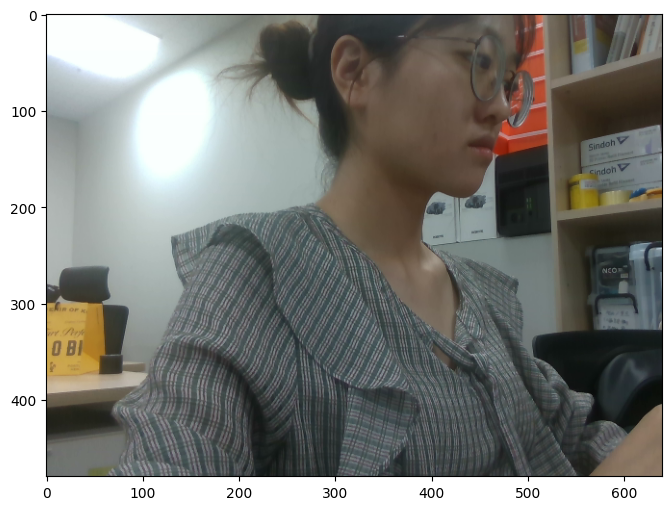

In [6]:
color = np.asanyarray(color_frame.get_data())
plt.rcParams["axes.grid"] = False
plt.rcParams['figure.figsize'] = [12, 6]
plt.imshow(color)

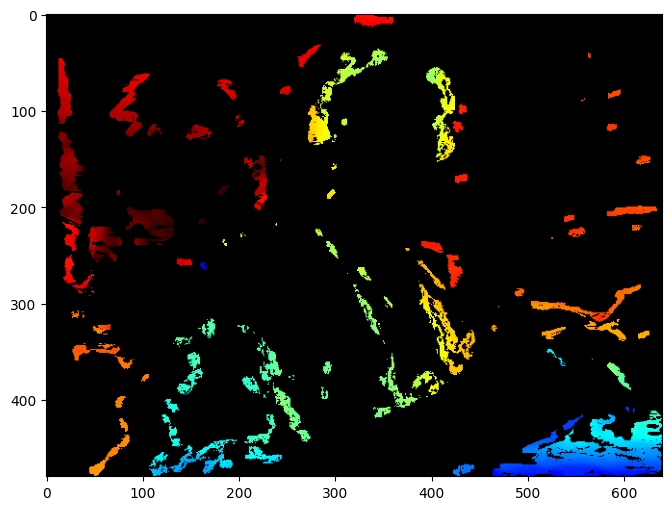

In [7]:
colorizer = rs.colorizer()
colorized_depth = np.asanyarray(colorizer.colorize(depth_frame).get_data())
plt.imshow(colorized_depth)

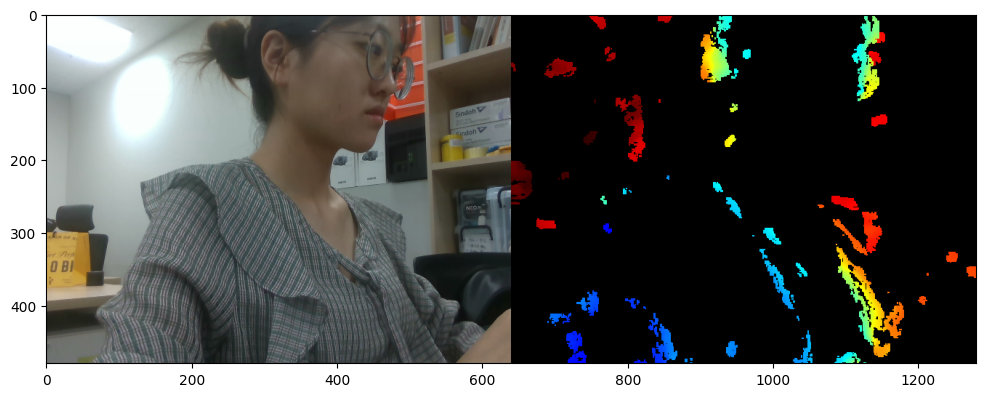

In [8]:
# Create alignment primitive with color as its target stream:
align = rs.align(rs.stream.color)
frameset = align.process(frameset)

# Update color and depth frames:
aligned_depth_frame = frameset.get_depth_frame()
colorized_depth = np.asanyarray(colorizer.colorize(aligned_depth_frame).get_data())

# Show the two frames together:
images = np.hstack((color, colorized_depth))
plt.imshow(images)

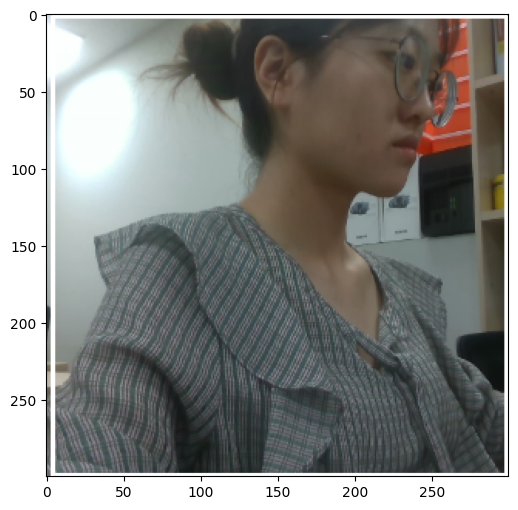

In [10]:
# Standard OpenCV boilerplate for running the net:
height, width = color.shape[:2]
expected = 300
aspect = width / height
resized_image = cv2.resize(color, (round(expected * aspect), expected))
crop_start = round(expected * (aspect - 1) / 2)
crop_img = resized_image[0:expected, crop_start:crop_start+expected]

net = cv2.dnn.readNetFromCaffe("/content/drive/MyDrive/depth.bag/MobileNetSSD_deploy.prototxt.txt", "/content/drive/MyDrive/depth.bag/MobileNetSSD_deploy.caffemodel")
inScaleFactor = 0.007843
meanVal       = 127.53
classNames = ("background", "aeroplane", "bicycle", "bird", "boat",
              "bottle", "bus", "car", "cat", "chair",
              "cow", "diningtable", "dog", "horse",
              "motorbike", "person", "pottedplant",
              "sheep", "sofa", "train", "tvmonitor")

blob = cv2.dnn.blobFromImage(crop_img, inScaleFactor, (expected, expected), meanVal, False)
net.setInput(blob, "data")
detections = net.forward("detection_out")

label = detections[0,0,0,1]
conf  = detections[0,0,0,2]
xmin  = detections[0,0,0,3]
ymin  = detections[0,0,0,4]
xmax  = detections[0,0,0,5]
ymax  = detections[0,0,0,6]

className = classNames[int(label)]

cv2.rectangle(crop_img, (int(xmin * expected), int(ymin * expected)),
             (int(xmax * expected), int(ymax * expected)), (255, 255, 255), 2)
cv2.putText(crop_img, className,
            (int(xmin * expected), int(ymin * expected) - 5),
            cv2.FONT_HERSHEY_COMPLEX, 0.5, (255,255,255))

plt.imshow(crop_img)

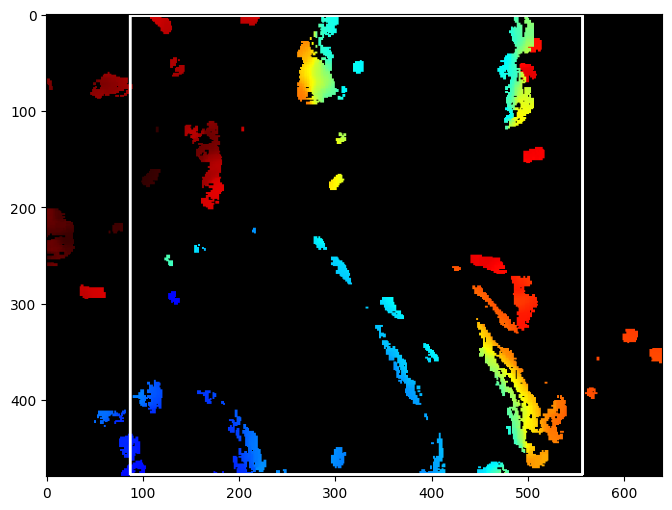

In [11]:
scale = height / expected
xmin_depth = int((xmin * expected + crop_start) * scale)
ymin_depth = int((ymin * expected) * scale)
xmax_depth = int((xmax * expected + crop_start) * scale)
ymax_depth = int((ymax * expected) * scale)
xmin_depth,ymin_depth,xmax_depth,ymax_depth
cv2.rectangle(colorized_depth, (xmin_depth, ymin_depth),
             (xmax_depth, ymax_depth), (255, 255, 255), 2)
plt.imshow(colorized_depth)

In [12]:
depth = np.asanyarray(aligned_depth_frame.get_data())
# Crop depth data:
depth = depth[xmin_depth:xmax_depth,ymin_depth:ymax_depth].astype(float)

# Get data scale from the device and convert to meters
depth_scale = profile.get_device().first_depth_sensor().get_depth_scale()
depth = depth * depth_scale
dist,_,_,_ = cv2.mean(depth)
print("Detected a {0} {1:.3} meters away.".format(className, dist))

Detected a person 0.0937 meters away.


In [13]:
# 각 방향의 길이를 픽셀 단위로 계산
x_length_pixels = xmax_depth - xmin_depth
y_length_pixels = ymax_depth - ymin_depth

# 깊이 데이터를 미터 단위로 변환하는 스케일 값
depth_scale = profile.get_device().first_depth_sensor().get_depth_scale()

# 카메라의 특정 해상도에 따른 변환 (해상도가 알려진 경우)
# 예: 특정 카메라 해상도와 FOV(Field of View)에 기반하여 계산할 수 있음

# 예를 들어, FOV와 해상도가 알려진 경우 이를 통해 미터 단위로 변환
# 여기서는 단순히 픽셀 수에 depth_scale을 곱하여 미터 단위로 변환하는 예제
x_length_meters = x_length_pixels * depth_scale
y_length_meters = y_length_pixels * depth_scale

print("Object width (x length): {:.3f} meters".format(x_length_meters))
print("Object height (y length): {:.3f} meters".format(y_length_meters))


Object width (x length): 0.470 meters
Object height (y length): 0.477 meters
